---
#### Slice id별 , uplink/downlink 별 미리 준비된 데이터를 가지고 온다. 
#### 미리 준비된 데이터의 경우, 네이블로부터 받은 데이터가 너무 클 경우 마지막 부분만 잘라서 갖고 있도록 하자. 
#### Slice id별, uplink/downlink별 모든 데이터를 가지고 있어야하고, 데이터명도 그렇게 통일 시켜야 한다. 
---

---
#### 미리 준비된 데이터를 가지고 와, 새로 입력된 데이터와 합해준다.
---

In [ ]:
import warnings
import numpy as np
import sys
warnings.filterwarnings('ignore')

import pandas as pd
ct = pd.read_csv(str(sys.argv[1])+'-'+str(sys.argv[2])+'.csv')
ct = ct.drop(['Unnamed: 0'], axis =1)
ct.columns = ['data']
train = np.concatenate([ct.data.values, np.array([float(sys.argv[4])])])

In [1]:
import pandas as pd

ct = pd.read_csv('training-data-Slice01-20200118.csv')

In [2]:
ct = ct[['UPLINK_THROUGHPUT']]
ct.columns = ['data']

In [3]:
train = ct.data.values

In [19]:
import rrcf

# Set tree parameters
num_trees = 64
shingle_size = 72
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)
    
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)  ### tree size를 크게 하면 오랫동안의 데이터를 기억하겟다. 
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
        
avg_codisp_list = pd.Series([v for v in avg_codisp.values()])

# Normalize anomaly scores to (0, 1)
avg_codisp_list = ((avg_codisp_list - avg_codisp_list.min())
              / (avg_codisp_list.max() - avg_codisp_list.min()))

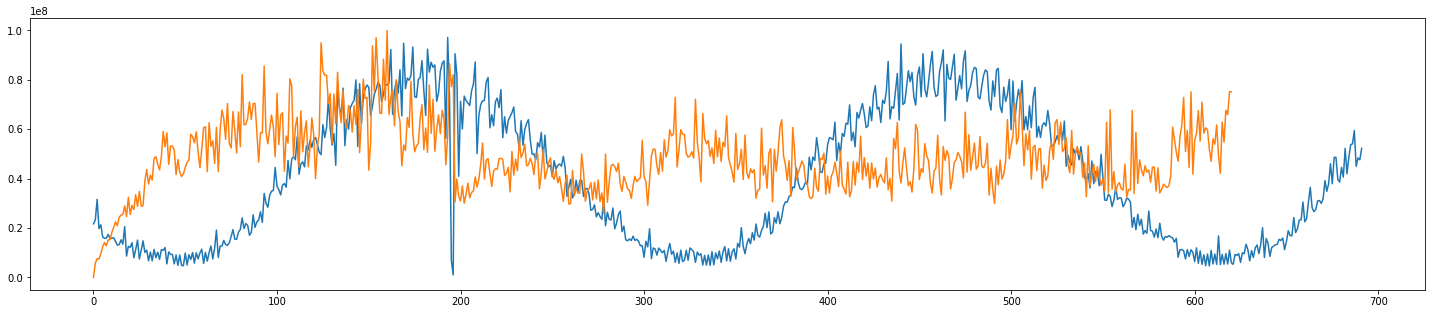

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,5))
plt.plot(ct.data.values)
plt.plot(avg_codisp_list*1e8)
plt.show()

---
#### 맨 앞 데이터를 뺀 나머지를 다시 덮어쓰기로 저장한다.
---

In [ ]:
pd.DataFrame(train[1: ]).to_csv((str(sys.argv[1])+'-'+str(sys.argv[2])+'.csv'))

---
#### 최종출력 : slice id, type은 그대로 나오고, 시간도 그대로 나오는 걸로 일단은. 시간은 다른 방식으로 하기 원하시면 바꿔줘야 한다.
---

In [ ]:
import time, datetime
from datetime import timedelta
a = datetime.datetime.strptime(sys.argv[3], "%Y-%m-%dT%H:%M:%S")

print('status','slice-id','type', 'time', 'value', sep = ',')

if 1 > avg_codisp_list.values[-1] > 0:
    print('0x64'+str(200), sys.argv[1], sys.argv[2],sys.argv[3], avg_codisp_list.values[-1], sep= ',')
else:
    print('0x64'+str(500), sys.argv[1], sys.argv[2],sys.argv[3], avg_codisp_list.values[-1], sep= ',')